In [55]:
from collections import deque

In [56]:
import nbimporter
from fct_usuelles import lire_graphe, afficher_graphe, visualiser_graphe_par_etape

In [57]:
def successeurs(etat, graphe):
    """
    Retourne les successeurs (voisins) d'un sommet donné.
    :param etat: Sommet actuel.
    :param graphe: Liste d'adjacence du graphe.
    :return: Liste des successeurs sous la forme (action, successeur).
    """
    return [(1, voisin) for voisin in graphe.get(etat, [])]  # Coût de chaque déplacement = 1



In [58]:
def test_but(etat, objectif):
    """
    Vérifie si un sommet est l'état terminal (objectif atteint).
    :param etat: Sommet actuel.
    :param objectif: Sommet cible.
    :return: True si l'objectif est atteint, False sinon.
    """
    return etat == objectif


In [59]:
def recherche(etat_initial, successeurs, test_but, cout_action=None):
    """
    Algorithme générique de recherche.

    :param etat_initial: État de départ.
    :param successeurs: Fonction qui retourne les états accessibles depuis un état donné.
    :param test_but: Fonction qui vérifie si un état est terminal.
    :param cout_action: Fonction optionnelle pour calculer le coût d'une action. Par défaut : pas de coût.
    :return: Chemin vers l'état terminal, coût total.
    """
    # Initialisation : créer la liste des noeuds à traiter
    noeuds_a_traiter = deque([{"etat": etat_initial, "chemin": [etat_initial], "cout": 0}])  # File ou pile

    while noeuds_a_traiter:
        # Extraire un nœud (FIFO pour BFS, LIFO pour DFS si on utilise une liste normale)
        noeud = noeuds_a_traiter.popleft()  # Utiliser .pop() pour DFS
        
        # Vérifier si l'état courant est un état terminal
        if test_but(noeud["etat"]):
            return noeud["chemin"], noeud["cout"]
        
        # Générer les successeurs
        for action, prochain_etat in successeurs(noeud["etat"]):
            nouveau_chemin = noeud["chemin"] + [prochain_etat]
            nouveau_cout = noeud["cout"] + (cout_action(action) if cout_action else 0)
            
            # Créer un nouveau nœud et l'ajouter à la liste
            nouveau_noeud = {"etat": prochain_etat, "chemin": nouveau_chemin, "cout": nouveau_cout}
            noeuds_a_traiter.append(nouveau_noeud)

    # Si on a parcouru tous les nœuds sans trouver la solution
    return None, float("inf")


In [64]:
def main(fichier_graphe):
    # Lecture du graphe
    graphe = lire_graphe(fichier_graphe)
    #print("Graphe lu depuis le fichier :")
    #for sommet, voisins in graphe.items():
    #    print(f"{sommet}: {voisins}")

    # Définir l'état initial et l'objectif
    sommet_depart = next(iter(graphe))  # Premier sommet trouvé
    sommet_objectif = 34  # Exemple d'objectif (choisissez un sommet existant dans le graphe)

    # Appliquer l'algorithme générique de recherche
    chemin, cout = recherche(
        etat_initial=sommet_depart,
        successeurs=lambda etat: successeurs(etat, graphe),
        test_but=lambda etat: test_but(etat, sommet_objectif)
    )
    
    # Résultat
    if chemin:
        print("\nChemin trouvé :")
        print(f"Chemin : {chemin}")
        print(f"Coût total : {cout}")
    else:
        print("\nAucun chemin trouvé vers l'objectif.")


In [65]:
#fichier = 'instances\Stranke94\Stranke94.mtx'
#fichier = 'instances\bn-mouse_visual-cortex_1\bn-mouse_visual-cortex_1.edges'
fichier = 'instances\karate\karate.mtx'
#fichier = 'instances\fb-pages-government\fb-pages-government.edges'

if __name__ == '__main__':
    main(fichier)


Chemin trouvé :
Chemin : [2, 14, 34]
Coût total : 0


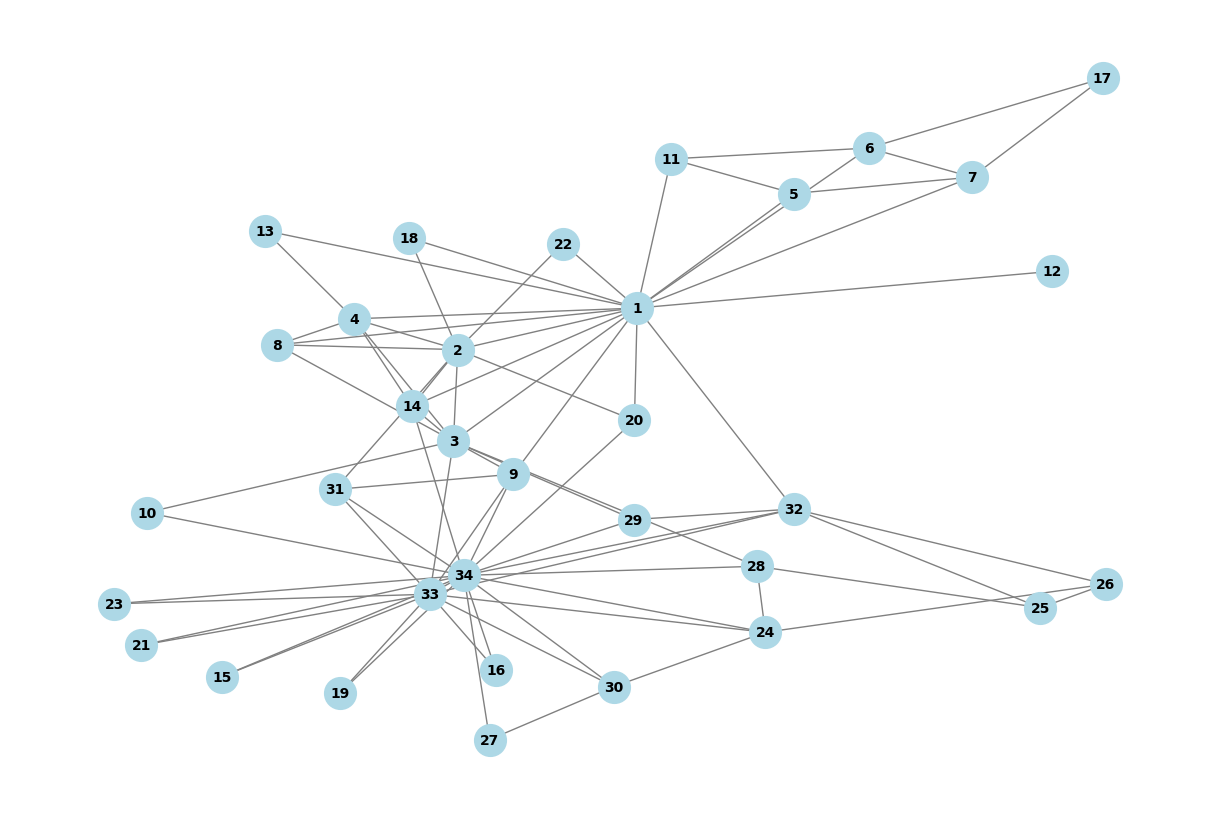

In [62]:
afficher_graphe(fichier)


dire un sommet va etre brulé au 3 tour par exemple
notre solution (du 2eme algo) sera le  centre (sommet) de la boule ayant le rayon le plus grand

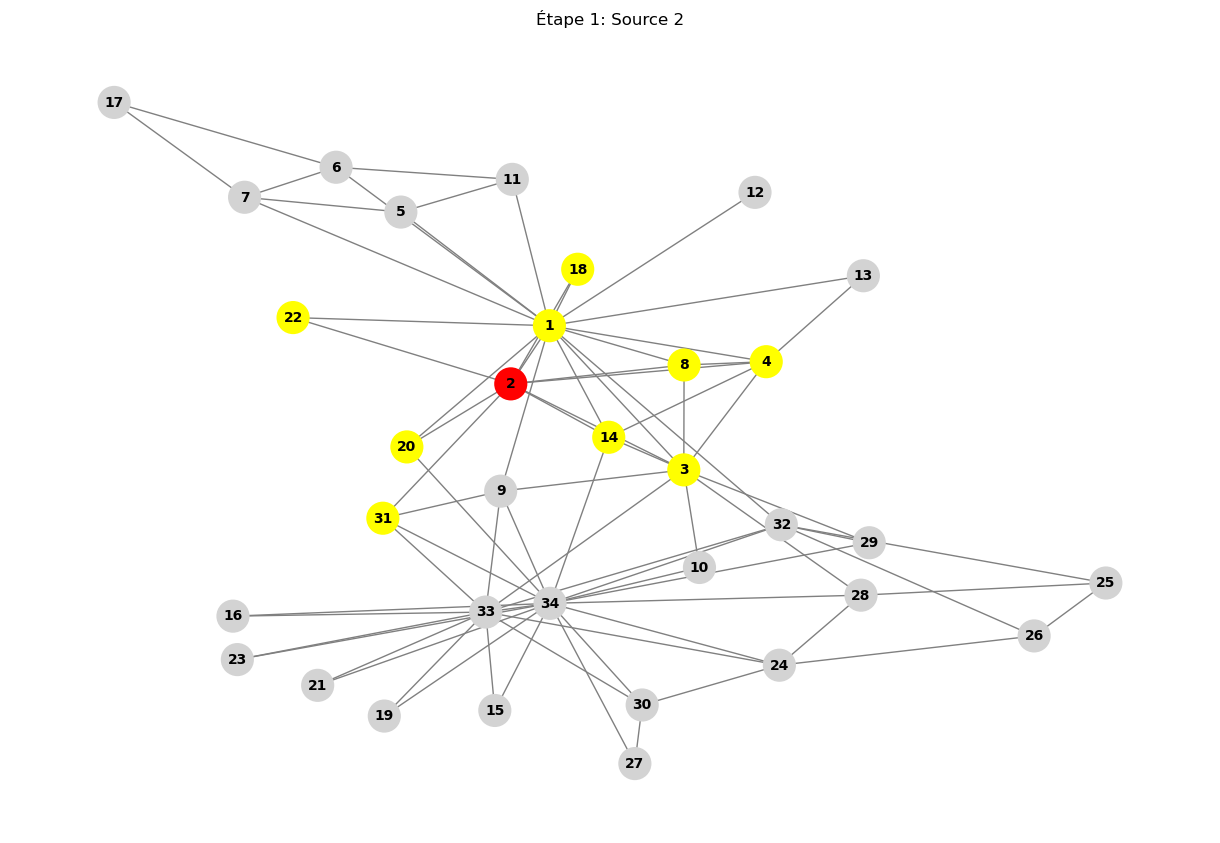

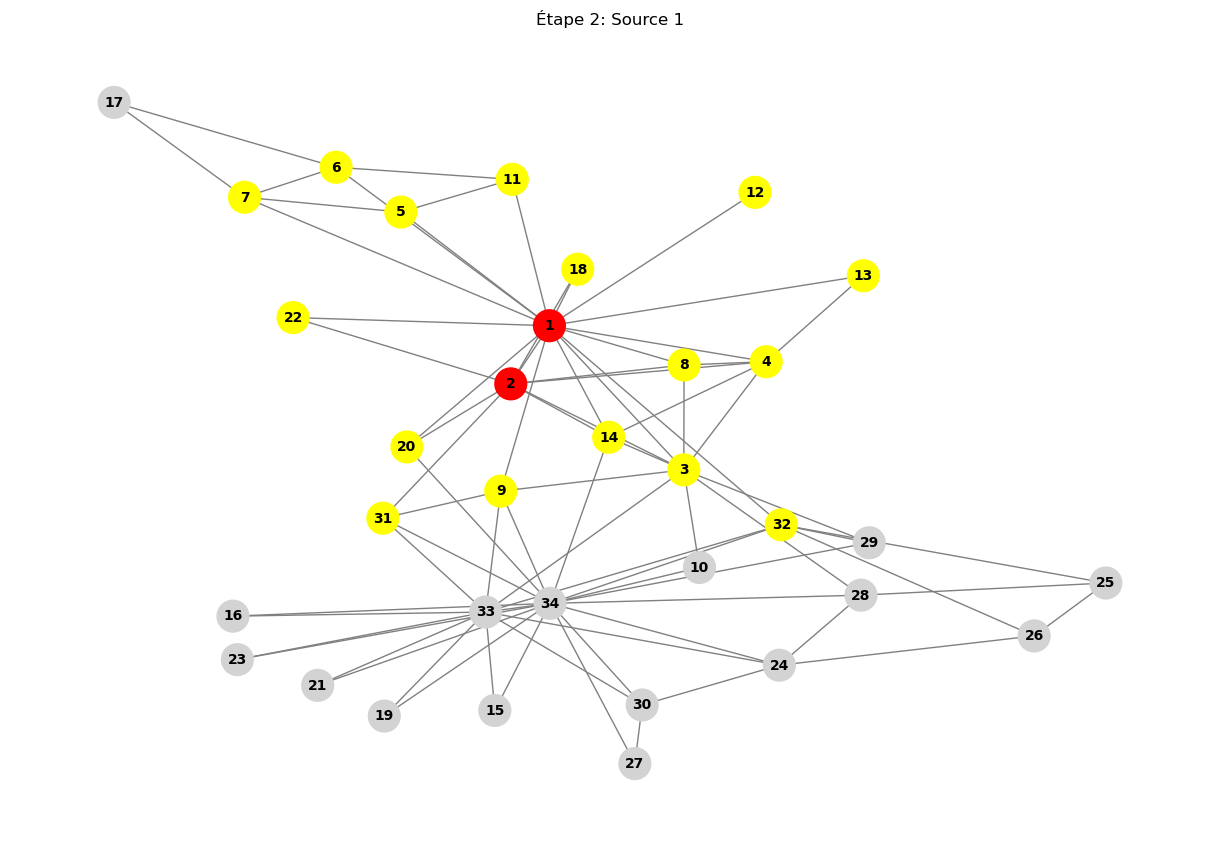

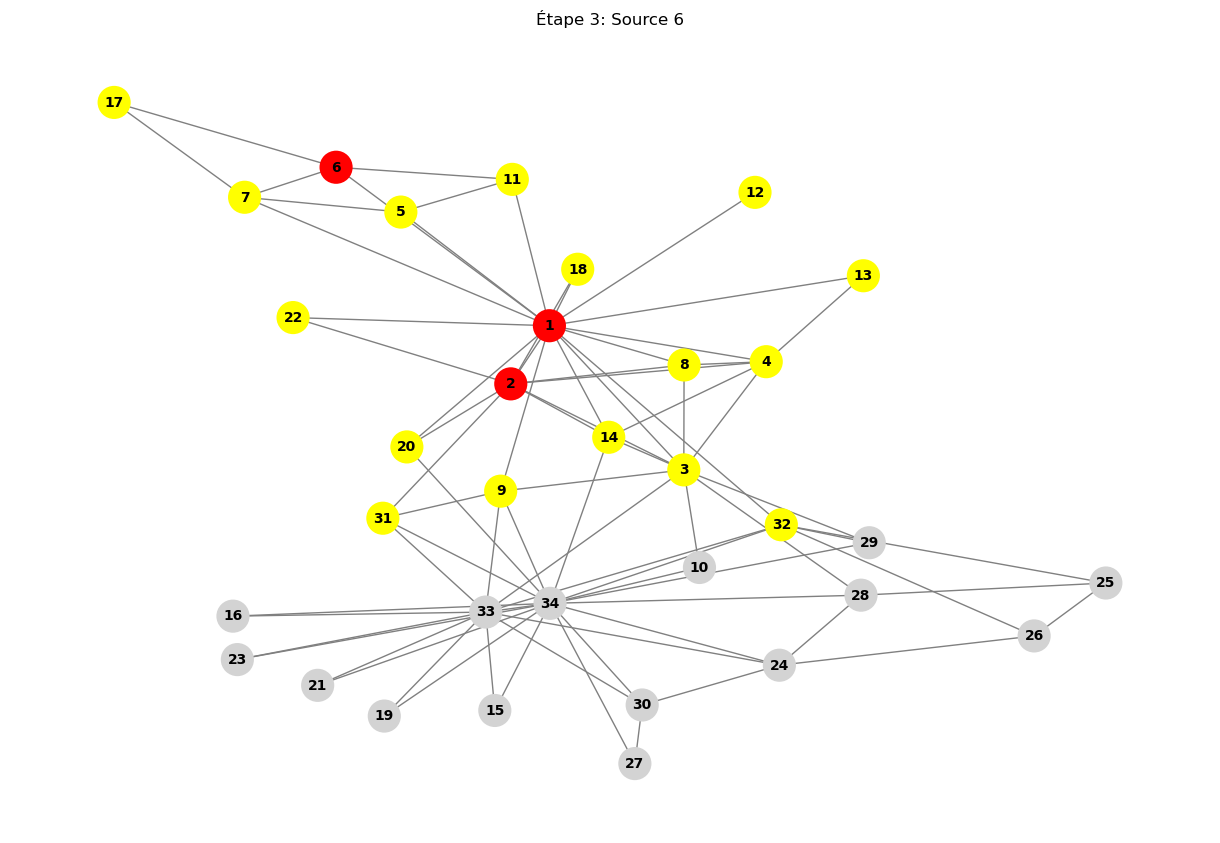

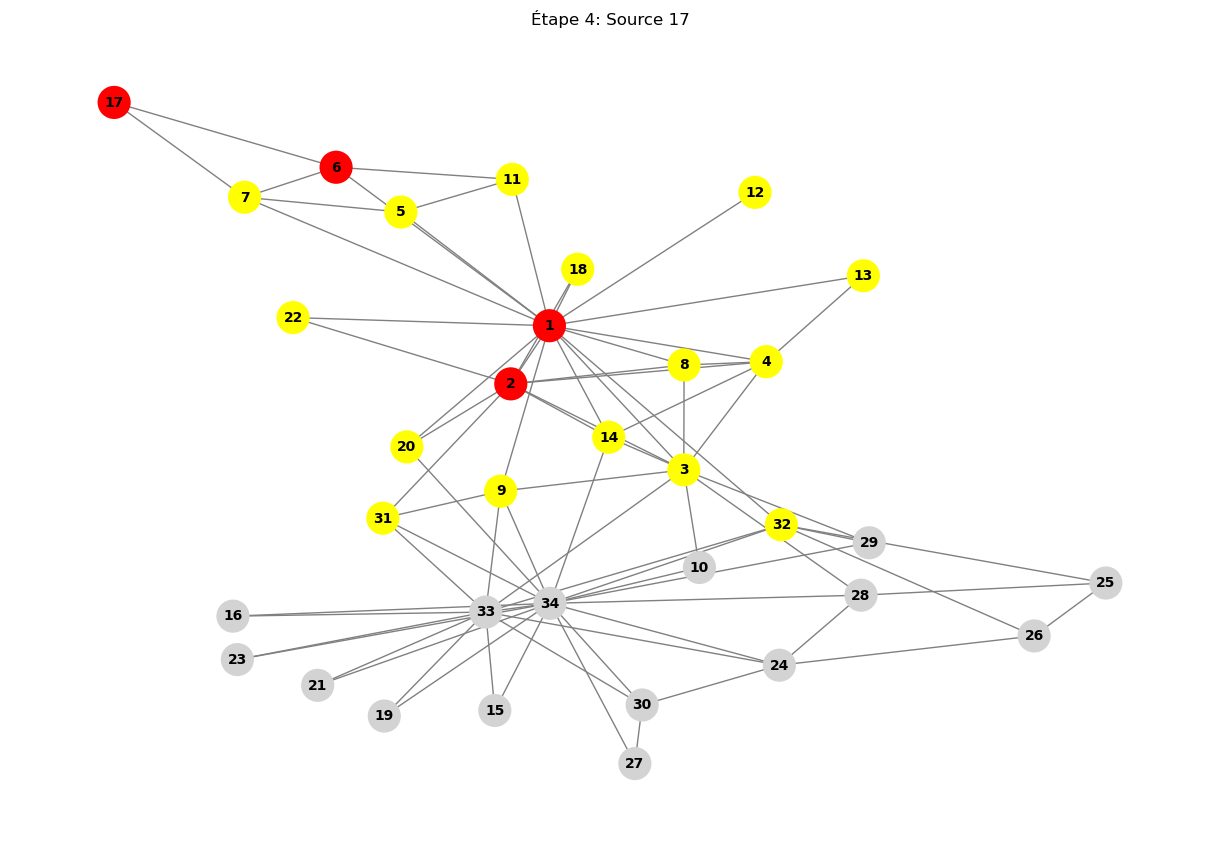

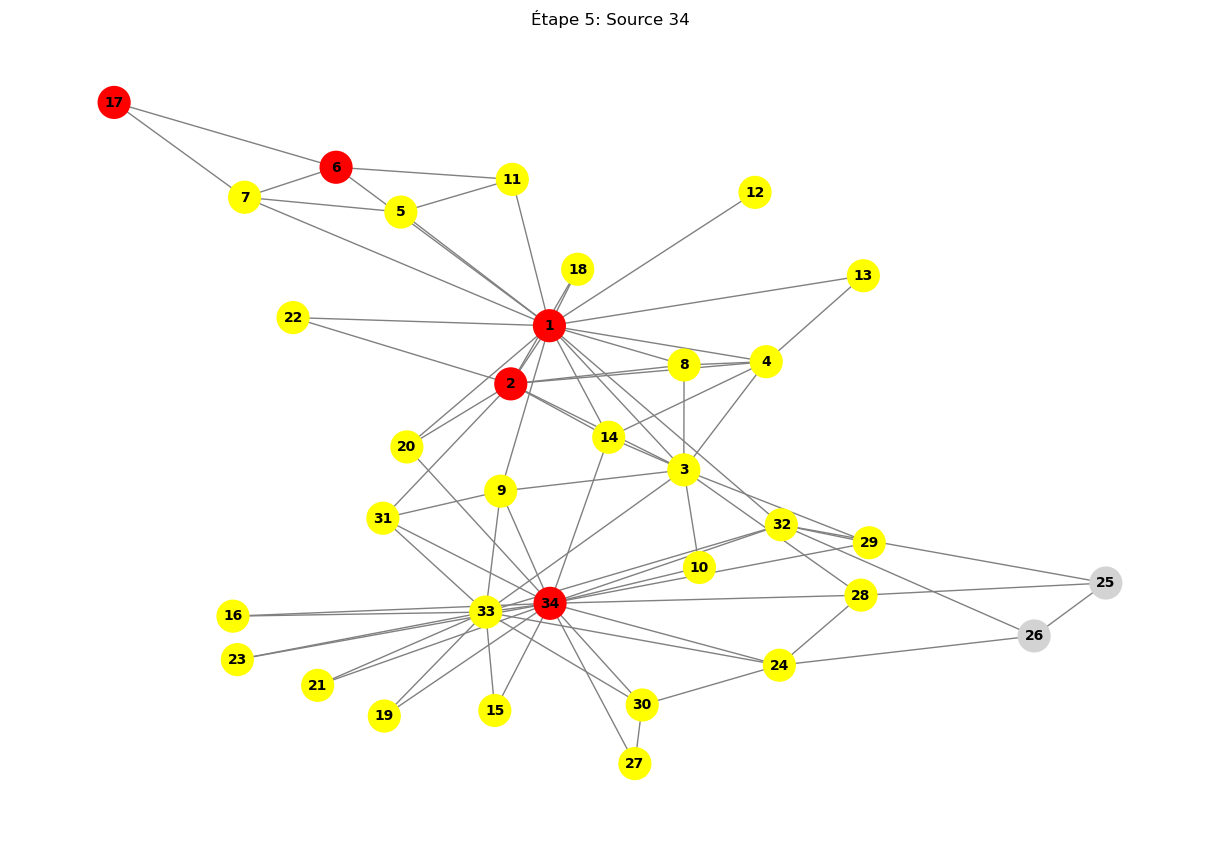

In [66]:
# Charger un graphe avec la fonction lire_graphe
graphe = lire_graphe(fichier)

# Chemin trouvé
chemin = [2, 1, 6, 17, 34]

# Visualiser le graphe par étape
visualiser_graphe_par_etape(graphe, chemin)
